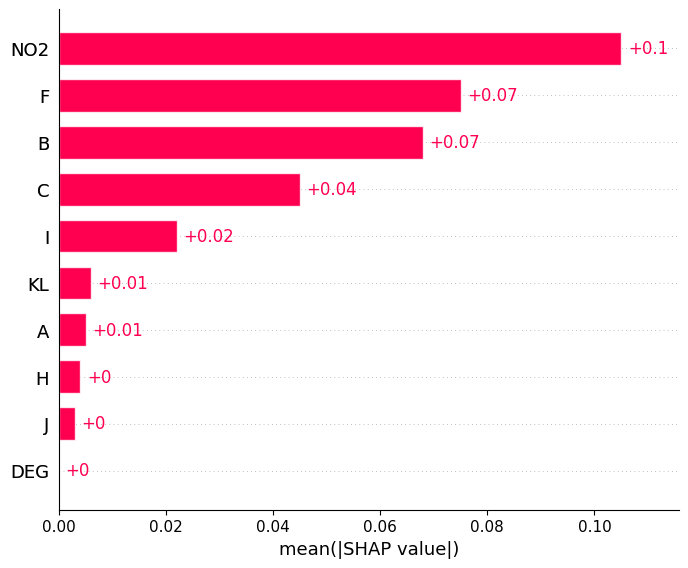

In [17]:
import shap
import numpy as np

# Feature names
feature_names = [
    "NO2", "A", "B", "C", "DEG",
    "F", "H", "I", "J", "KL"
]

# Mean |SHAP| values (approssimati)
mean_shap_values = np.array([
    0.105,  # NO2
    0.005,  # A
    0.068,  # B
    0.045,  # C
    0.000,  # DEG
    0.075,  # F
    0.004,  # H
    0.022,  # I
    0.003,  # J
    0.006   # KL
])

# SHAP expects per-sample values → fake 1-sample explanation
values = mean_shap_values.reshape(1, -1)

# Create Explanation object
expl = shap.Explanation(
    values=values,
    feature_names=feature_names
)

# SHAP bar plot (identical to summary_plot bar)
shap.plots.bar(expl)


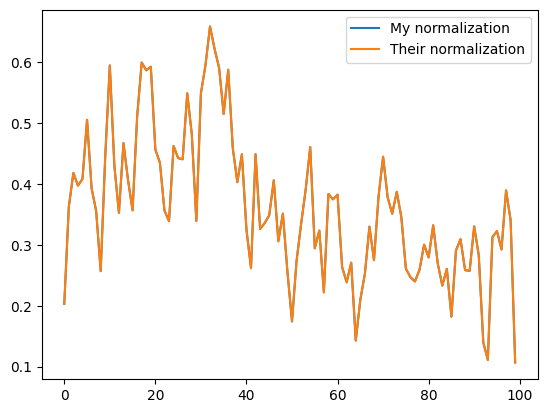

MAE:  0.13743935414648903 ME:  0.0
--------------------------------
Normalization values for 2020: min = 8.56, max = 92.1157
Normalization values for 2021: min = 10.6597, max = 87.7216
Normalization values for 2022: min = 11.9123, max = 94.5397
Normalization values for 2020_2022: min = 8.56, max = 94.5397


In [18]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
no2 = joblib.load(r"Concentrazioni_NO2/concentration_milan_NO2.pkl")
y_test = pd.read_excel(r"100-UFFICIALE\00-DATASET\C_train_norm.xlsx").to_numpy()

no2 = np.asarray(list(no2.values()))[1:len(y_test)+1]

min_, max_ = no2.min(), no2.max()
#y_test = y_test*(max_ - min_) + min_
no2 = (no2- min_)/(max_ - min_)

for i in range(1):
    plt.plot(no2[100*i:100*(i+1)], label="My normalization")
    plt.plot(y_test[100*i:100*(i+1)], label="Their normalization")
    plt.legend()
    plt.show()

print("MAE: ", np.mean(np.abs(no2 - y_test)), "ME: ", np.mean(no2 - y_test))
print("--------------------------------")
glob_min, glob_max = np.inf, -np.inf
norm_values = {}
for period in ["2020", "2021", "2022"]:

    no2 = joblib.load(r"Concentrazioni_NO2/concentration_milan_NO2.pkl")
    y_test = pd.read_excel(f"100-UFFICIALE\\00-DATASET\\C_val_{period}_norm.xlsx").to_numpy()

    no2_vals = np.array(list(no2.values()))
    no2_keys = np.array(list(no2.keys()))
    no2 = []
    for i in range(len(no2_keys)):
        if no2_keys[i].endswith(period):
            no2.append(no2_vals[i])
    no2 = np.asarray(no2)[1:]

    min_, max_ = no2.min(), no2.max()
    norm_values[period] = (min_, max_)
    if min_ < glob_min:
        glob_min = min_
    if max_ > glob_max:
        glob_max = max_

    print(f"Normalization values for {period}: min = {min_}, max = {max_}")
norm_values["2020_2022"] = (glob_min, glob_max)
print(f"Normalization values for 2020_2022: min = {glob_min}, max = {glob_max}")

In [31]:
from tensorflow.keras.models import load_model
import joblib
import pandas as pd

model = load_model("100-UFFICIALE\\01-MODELLI\\HCNN_NormoDati_100Trials.h5",
                   custom_objects={"mse": "mean_squared_error"})
#model.summary()

for period in ["2020_2022", "2020", "2021", "2022"]:
    X_test = joblib.load(f"100-UFFICIALE/00-DATASET/E_val_{period}_norm.pkl")
    y_test = pd.read_excel(f"100-UFFICIALE/00-DATASET/C_val_{period}_norm.xlsx")

    y_pred = model.predict([y_test, X_test[:-1]])


    min_, max_ = norm_values[period]
    y_test = y_test.to_numpy()*(max_ - min_) + min_
    y_pred = y_pred*(max_ - min_) + min_

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mae = mean_absolute_error(y_test[1:], y_pred[:-1])
    me = np.mean(y_test[1:] - y_pred[:-1])
    std = np.std(y_test[1:] - y_pred[:-1])
    corr = np.corrcoef(y_test[1:].flatten(), y_pred[:-1].flatten())[0, 1]
    print(f"Period: {period}")
    print(f"MAE: {mae:.3f} \nNMAE: {mae/np.mean(y_test):.3f}"+
          f"\nME: {me:.3f} \nNME: {me/np.mean(y_test):.3f} " +
          f"\nCORR: {corr:.3f} \nR^2: {r2_score(y_test[1:], y_pred[:-1]):.3f}\n" +
            f"STD of errors: {std:.3f}\n----------------------") 


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Period: 2020_2022
MAE: 6.997 
NMAE: 0.187
ME: 3.230 
NME: 0.086 
CORR: 0.866 
R^2: 0.695
STD of errors: 8.869
----------------------
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Period: 2020
MAE: 7.183 
NMAE: 0.195
ME: 3.351 
NME: 0.091 
CORR: 0.894 
R^2: 0.735
STD of errors: 8.909
----------------------
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Period: 2021
MAE: 7.001 
NMAE: 0.185
ME: 3.021 
NME: 0.080 
CORR: 0.857 
R^2: 0.682
STD of errors: 9.056
----------------------
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Period: 2022
MAE: 6.774 
NMAE: 0.181
ME: 2.882 
NME: 0.077 
CORR: 0.839 
R^2: 0.660
STD of errors: 8.722
----------------------


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Period: 2020_2022, thr: 25
Hit Ratio (POD): 0.870
False Alarm Ratio (FAR): 0.111


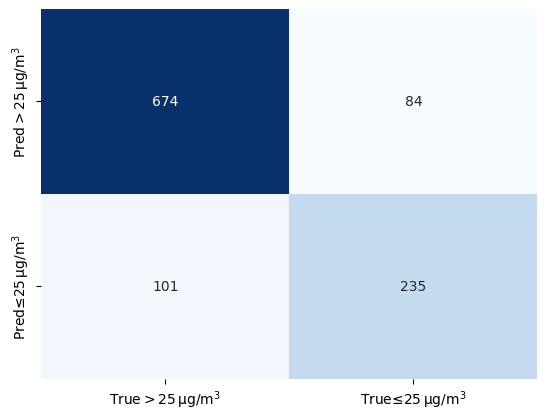

Period: 2020_2022, thr: 50
Hit Ratio (POD): 0.481
False Alarm Ratio (FAR): 0.127


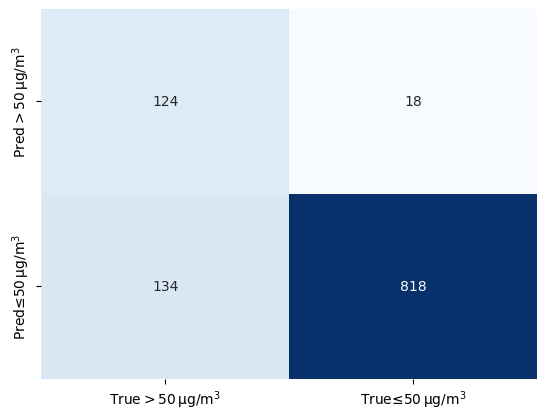

In [35]:
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

model = load_model("100-UFFICIALE\\01-MODELLI\\HCNN_NormoDati_100Trials.h5",
                   custom_objects={"mse": "mean_squared_error"})
#model.summary()

for period in ["2020_2022"]:#, "2020", "2021", "2022"]:
    X_test = joblib.load(f"100-UFFICIALE/00-DATASET/E_val_{period}_norm.pkl")
    y_test = pd.read_excel(f"100-UFFICIALE/00-DATASET/C_val_{period}_norm.xlsx")

    y_pred = model.predict([y_test, X_test[:-1]])


    min_, max_ = norm_values[period]
    y_test = y_test.to_numpy()*(max_ - min_) + min_
    y_pred = y_pred*(max_ - min_) + min_

    for threshold in [25, 50]:
        TP, FP, TN, FN = 0, 0, 0, 0
        for i in range(len(y_test[1:])):
            y_true = y_test[i+1]
            pred = y_pred[i]
            if y_true > threshold and pred > threshold:
                TP += 1
            elif y_true > threshold and pred <= threshold:
                FN += 1
            elif y_true <= threshold and pred > threshold:
                FP += 1
            else:
                TN += 1
        # Metriche
        hit_ratio = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        false_alarm_ratio = FP / (TP + FP) if (TP + FP) > 0 else np.nan

        print(f"Period: {period}, thr: {threshold}")
        print(f"Hit Ratio (POD): {hit_ratio:.3f}")
        print(f"False Alarm Ratio (FAR): {false_alarm_ratio:.3f}")
        fig = plt.figure()
        sns.heatmap([[TP, FP], [FN, TN]], annot=True, fmt="d", cbar=False, cmap="Blues")
        plt.xticks([0.5, 1.5], [f"$\\mathrm{{True > {threshold}\\,\\mu g/m^3}}$", 
                         f"$\\mathrm{{True ≤ {threshold}\\,\\mu g/m^3}}$"])
        plt.yticks([0.5, 1.5], [f"$\\mathrm{{Pred > {threshold}\\,\\mu g/m^3}}$", 
                                f"$\\mathrm{{Pred ≤ {threshold}\\,\\mu g/m^3}}$"])
        fig.savefig(f"figs/threshold_{threshold}_{period}.png", dpi = 300)
        plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


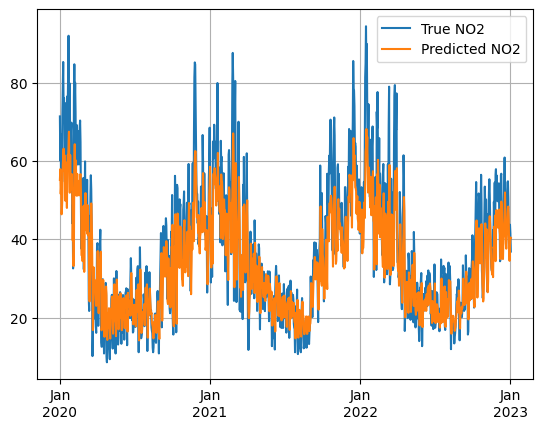

In [30]:
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

model = load_model("100-UFFICIALE\\01-MODELLI\\HCNN_NormoDati_100Trials.h5",
                   custom_objects={"mse": "mean_squared_error"})
#model.summary()

for period in ["2020_2022"]:#, "2020", "2021", "2022"]:
    X_test = joblib.load(f"100-UFFICIALE/00-DATASET/E_val_{period}_norm.pkl")
    y_test = pd.read_excel(f"100-UFFICIALE/00-DATASET/C_val_{period}_norm.xlsx")

    y_pred = model.predict([y_test, X_test[:-1]])


    min_, max_ = norm_values[period]
    y_test = y_test.to_numpy()*(max_ - min_) + min_
    y_pred = y_pred*(max_ - min_) + min_

    fig = plt.figure()
    plt.plot(y_test[1:], label="True NO2")
    plt.plot(y_pred[:-1], label="Predicted NO2")
    plt.grid()
    plt.legend()
    plt.xticks(np.arange(len(y_test[1:]))[::364], labels = ["Jan\n2020", "Jan\n2021", "Jan\n2022", "Jan\n2023"])
    fig .savefig(f"figs/true_vs_pred_{period}.png", dpi = 300)
    plt.show()

In [3]:
import pandas as pd

emissioni = pd.concat([pd.read_csv(f"Emissioni_NOx/nox_cams_{year}.csv") for year in [2020,2021,2022]])

for i in range(2, len(list(emissioni.columns))):
    min, max = emissioni.iloc[:,i].min(), emissioni.iloc[:,i].max()
    print(f"Column {list(emissioni.columns)[i]}: Min = {min}, Max = {max}")
emissioni

Column A_PublicPower: Min = 0.0, Max = 177.616362
Column B_Industry: Min = 0.0, Max = 442.124498
Column C_OtherStationaryComb: Min = 0.011257, Max = 219.338791
Column D_Fugitives: Min = 0.0, Max = 4.371835
Column E_Solvents: Min = 3e-05, Max = 0.491094
Column F_RoadTransport: Min = 0.0, Max = 305.129094
Column G_Shipping: Min = 0.0, Max = 0.179024
Column H_Aviation: Min = 0.0, Max = 268.753132
Column I_OffRoad: Min = 0.000657, Max = 20.139097
Column J_Waste: Min = 1.5e-05, Max = 3.699209
Column K_AgriLivestock: Min = 0.0, Max = 0.0
Column L_AgriOther: Min = 0.0, Max = 24.183894
Column SumAllSectors: Min = 0.026939, Max = 638.309268


,xutm,yutm,A_PublicPower,B_Industry,C_OtherStationaryComb,D_Fugitives,E_Solvents,F_RoadTransport,G_Shipping,H_Aviation,I_OffRoad,J_Waste,K_AgriLivestock,L_AgriOther,SumAllSectors
0,450000,4930000,0.0,0.000000,1.548949,0.0,0.000930,8.510323,0.0,0.0,1.853923,0.000964,0.0,0.0,11.915089
1,450000,4936000,0.0,0.000000,2.823348,0.0,0.001684,8.540514,0.0,0.0,2.566664,0.001745,0.0,0.0,13.933955
2,450000,4942000,0.0,0.316322,7.034451,0.0,0.009270,21.703760,0.0,0.0,3.201470,0.054410,0.0,0.0,32.319682
3,450000,4948000,0.0,0.769530,6.218603,0.0,0.008538,20.016058,0.0,0.0,2.319567,0.117849,0.0,0.0,29.450144
4,450000,4954000,0.0,0.830792,4.945062,0.0,0.006285,15.330464,0.0,0.0,1.677823,0.124192,0.0,0.0,22.914620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,714000,5170000,0.0,0.000000,0.955306,0.0,0.001514,5.037805,0.0,0.0,0.070720,0.001268,0.0,0.0,6.066613
2021,714000,5176000,0.0,0.000000,1.336266,0.0,0.001612,11.114052,0.0,0.0,0.232825,0.001350,0.0,0.0,12.686104
2022,714000,5182000,0.0,0.000000,2.714664,0.0,0.003964,20.409033,0.0,0.0,0.914897,0.003320,0.0,0.0,24.045879
2023,714000,5188000,0.0,0.000000,2.822610,0.0,0.004690,18.125666,0.0,0.0,0.814295,0.003928,0.0,0.0,21.771189


In [24]:
import joblib
import numpy as np
sectors = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]
norm_values_nox = {}
for sector in sectors:
    year_min, year_max = np.inf, -np.inf
    for year in [2020, 2021, 2022]:

        temp_prof = joblib.load(f"Profili_temporali_NOx/temporal_profile_{year}.pkl")
        emissioni = pd.read_csv(f"Emissioni_NOx/nox_cams_{year}.csv")
        emissioni.columns = ["xutm","yutm"] + sectors + ["Total"]
        emissioni_settore = emissioni[["xutm", "yutm", sector]]
        
        for day in range(1, len(temp_prof)+1):
            temp_prof_settore = temp_prof[day][["xutm", "yutm", sector]]
            joined = emissioni_settore.merge(temp_prof_settore, on=["xutm", "yutm"])
            joined[sector] = joined[sector + "_x"] * joined[sector + "_y"]
            joined = joined[["xutm", "yutm", sector]]
            min, max = joined[sector].min(), joined[sector].max()
            if min < year_min:
                year_min = min
            if max > year_max:
                year_max = max
    print(f"Settore {sector}, Min = {year_min}, Max = {year_max}")
    norm_values_nox[sector] = (year_min, year_max)



Settore A, Min = 0.0, Max = 0.629543457874276
Settore B, Min = 0.0, Max = 1.5029967861865643
Settore C, Min = 6.825738510815427e-06, Max = 2.160779620253573
Settore D, Min = 0.0, Max = 0.015075293103448274
Settore E, Min = 3.5996835443037994e-08, Max = 0.001680058421052632
Settore F, Min = 0.0, Max = 1.2014796509291565
Settore G, Min = 0.0, Max = 0.0005144367969406062
Settore H, Min = 0.0, Max = 0.9739668748419703
Settore I, Min = 3.2334301412872853e-07, Max = 0.11876601831637196
Settore J, Min = 4.032258064516129e-08, Max = 0.01062991091954023
Settore K, Min = 0.0, Max = 0.0
Settore L, Min = 0.0, Max = 0.39478855750381175


In [ ]:
import joblib
import numpy as np
sectors = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]
norm_values_nox = {}
for sector in sectors:
    year_min, year_max = np.inf, -np.inf
    for year in [2020, 2021, 2022]:

        temp_prof = joblib.load(f"Profili_temporali_NOx/temporal_profile_{year}.pkl")
        emissioni = pd.read_csv(f"Emissioni_NOx/nox_cams_{year}.csv")
        emissioni.columns = ["xutm","yutm"] + sectors + ["Total"]
        emissioni_settore = emissioni[["xutm", "yutm", sector]]
        
        for day in range(1, len(temp_prof)+1):
            temp_prof_settore = temp_prof[day][["xutm", "yutm", sector]]
            joined = emissioni_settore.merge(temp_prof_settore, on=["xutm", "yutm"])
            joined[sector] = joined[sector + "_x"] * joined[sector + "_y"]
            joined = joined[["xutm", "yutm", sector]]
            min, max = joined[sector].min(), joined[sector].max()
            if min < year_min:
                year_min = min
            if max > year_max:
                year_max = max
    print(f"Settore {sector}, Min = {year_min}, Max = {year_max}")
    norm_values_nox[sector] = (year_min, year_max)

['100-UFFICIALE/100-PYTHON/norm_values_nox.pkl']

EPSG:32632


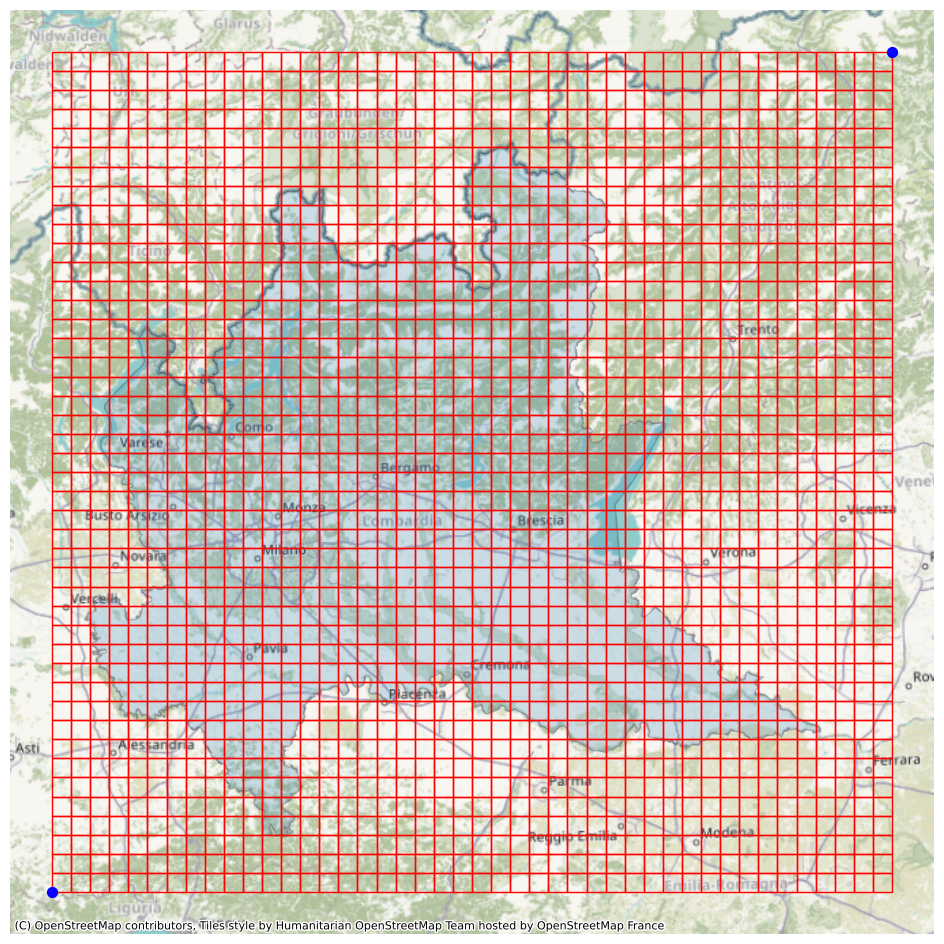

In [28]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# 1️⃣ Carica shapefile
gdf_shp = gpd.read_file("Reg01012025/Reg01012025_WGS84.shp")
gdf_shp = gdf_shp[gdf_shp["COD_REG"] == 3]  # filtro regione
print(gdf_shp.crs)

# 2️⃣ Definisci il rettangolo principale (UTM)
p1 = (450000, 4930000)  # basso-sinistra
p2 = (714000, 5194000)  # alto-destra

min_x, min_y = min(p1[0], p2[0]), min(p1[1], p2[1])
max_x, max_y = max(p1[0], p2[0]), max(p1[1], p2[1])

# 3️⃣ Genera la griglia
step = 6000  # passo 6000 m

x_coords = np.arange(min_x, max_x, step)
y_coords = np.arange(min_y, max_y, step)

polygons = []
for x in x_coords:
    for y in y_coords:
        poly = Polygon([
            (x, y),
            (x + step, y),
            (x + step, y + step),
            (x, y + step),
            (x, y)
        ])
        polygons.append(poly)

gdf_grid = gpd.GeoDataFrame({'geometry': polygons}, crs="EPSG:32633")

gdf_points = gpd.GeoDataFrame({'geometry':[Point(p1), Point(p2)]}, crs="EPSG:32633")

# 5️⃣ Plot
fig, ax = plt.subplots(figsize=(12,12))
gdf_shp.plot(ax=ax, edgecolor='black', alpha=0.2)
gdf_grid.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
gdf_points.plot(ax=ax, color='blue', markersize=50)

ctx.add_basemap(ax, crs=gdf_shp.crs.to_string())
ax.set_axis_off()
plt.show()
